# Chapter 1: Basics and Linear Models

In [1]:
# Chapter 1 exercise imports and data
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, GammaRegressor
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error


diamonds = pd.read_parquet("diamonds.parquet")  # Or sns.load_dataset("diamonds")

ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Exercise on linear regression

In [2]:
# Via scikit-learn
y = diamonds["price"]

model = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", ["carat"]),
            ("dummies", OneHotEncoder(categories=ord_levels, drop="first"), ord_vars),
        ],
        verbose_feature_names_out=False,
    ),
    LinearRegression(),
)
model.fit(diamonds, y)

rmse = root_mean_squared_error(y, model.predict(diamonds))
print(f"RMSE: {rmse:.3f}")
print(f"R-squared: {model.score(diamonds, y):.2%}")
print("Intercept", model[-1].intercept_)

results = pd.DataFrame(
    model[-1].coef_, columns=["Estimates"], index=model[:-1].get_feature_names_out()
)
results

RMSE: 1156.648
R-squared: 91.59%
Intercept -944.9008751128845


,Estimates
carat,8886.128884
color_E,-211.682482
color_F,-303.310033
color_G,-506.199536
color_H,-978.697664
color_I,-1440.301902
color_J,-2325.222360
cut_Premium,-128.858534
cut_Very Good,-149.537561
cut_Good,-342.486990


In [3]:
# Via statsmodels
model2 = smf.ols("price ~ carat + color + cut + clarity", data=diamonds).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.264e+04
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:37:38   Log-Likelihood:            -4.5699e+05
No. Observations:               53940   AIC:                         9.140e+05
Df Residuals:                   53921   BIC:                         9.142e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -944.9009     31.395    -30.098      0.000   -1006.434    -883.367
color[T.E]        -211.6825     18.316    -11.557      0.000    -247.582    -175.783
color[T.F]        -303.3100     18.509    -16.387      0.000    -339.589    -267.031
color[T.G]        -506.1995     18.122    -27.933      0.000    -541.719    -470.680
color[T.H]        -978.6977     19.272    -50.784      0.000   -1016.471    -940.925
color[T.I]       -1440.3019     21.646    -66.538      0.000   -1482.729   -1397.875
color[T.J]       -2325.2224     26.723    -87.013      0.000   -2377.599   -2272.846
cut[T.Premium]    -128.8585     12.894     -9.994      0.000    -154.131    -103.586
cut[T.Very Good]  -149.5376     13.265    -11.273      0.000    -175.538    -123.537
cut[T.Good]       -342.4870     18.524    -18.489      0.000    -378.794    -306.180
cut[T.Fair]       -998.2544     30.656    -32.563      0.000   -1058.341    -938.168
clarity[T.VVS1]   -347.6192     33.440    -10.395      0.000    -413.162    -282.076
clarity[T.VVS2]   -452.4474     31.951    -14.160      0.000    -515.072    -389.822
clarity[T.VS1]    -884.7679     30.456    -29.050      0.000    -944.463    -825.073
clarity[T.VS2]   -1201.8177     29.721    -40.436      0.000   -1260.072   -1143.564
clarity[T.SI1]   -1845.9589     29.857    -61.827      0.000   -1904.479   -1787.439
clarity[T.SI2]   -2793.6969     31.085    -89.873      0.000   -2854.624   -2732.770
clarity[T.I1]    -5419.6468     52.136   -103.952      0.000   -5521.834   -5317.460
carat             8886.1289     12.034    738.437      0.000    8862.543    8909.715
==============================================================================
Omnibus:                    15285.474   Durbin-Watson:                   0.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183262.957
Skew:                           1.022   Prob(JB):                         0.00
Kurtosis:                      11.796   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
print(f"RMSE: {root_mean_squared_error(y, model2.predict(diamonds)):.3f}")

RMSE: 1156.648


**Comments**

- **Model quality:** About 92% of price variations are explained by covariates. Typical prediction error is 1157 USD.
- **Effects:** All effects point into the intuitively right direction (larger stones are more expensive, worse color are less expensive etc.)
- **Practical perspective:** Additivity in color, cut and clarity are not making sense. Their effects should get larger with larger diamond size. This can be solved by adding interaction terms with carat or, much easier, to switch to a logarithmic response.

## Exercise on GLMs

In [5]:
# Via statsmodels
model = smf.glm(
    "price ~ np.log(carat) + color + cut + clarity",
    data=diamonds,
    family=sm.families.Gamma(sm.families.links.Log()),
).fit()

print(model.summary())

bias = diamonds["price"].mean() / model.predict(diamonds).mean() - 1
print(f"Relative bias on USD scale: {bias:.3%}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                53940
Model:                            GLM   Df Residuals:                    53921
Model Family:                   Gamma   Df Model:                           18
Link Function:                    Log   Scale:                        0.019471
Method:                          IRLS   Log-Likelihood:            -3.8857e+05
Date:                Fri, 16 Feb 2024   Deviance:                       978.68
Time:                        15:37:41   Pearson chi2:                 1.05e+03
No. Iterations:                    12   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            9.1446      0.004  

In [6]:
# Via scikit-learn
y = diamonds["price"]

# Define log_carat outside pipeline as it is tricky to track feature names
diamonds["log_carat"] = np.log(diamonds["carat"])

# Define and fit model pipeline. Note: GammaRegressor directly uses log-link
take_log = FunctionTransformer(np.log, feature_names_out="one-to-one")
model2 = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("log_carat", take_log, ["carat"]),
            ("dummies", OneHotEncoder(categories=ord_levels, drop="first"), ord_vars),
        ],
        verbose_feature_names_out=False,
    ),
    GammaRegressor(alpha=0, solver="newton-cholesky"),
)
model2.fit(diamonds, y)

# Performance
d2 = model2.score(diamonds, y)
print(f"Percent deviance explained: {d2:.2%}")

# Relative bias
bias2 = y.mean() / model2.predict(diamonds).mean() - 1
print(f"Relative bias on USD scale: {bias2:.3%}")

# Fitted coefficients
print("Intercept", model2[-1].intercept_)
results = pd.DataFrame(
    model2[-1].coef_, columns=["Estimates"], index=model2[:-1].get_feature_names_out()
)
results

d:\ml_lecture\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\ml_lecture\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Percent deviance explained: 98.15%
Relative bias on USD scale: 0.336%
Intercept 9.144584407895891


,Estimates
carat,1.881556
color_E,-0.056294
color_F,-0.096366
color_G,-0.163527
color_H,-0.253498
color_I,-0.374275
color_J,-0.511088
cut_Premium,-0.020745
cut_Very Good,-0.044901
cut_Good,-0.081495


**Comment:** The coefficients are very similar to the linear regression with log(price) as response. This makes sense as we interpret the coefficients in the same way! The bias is only 0.3%, i.e., much smaller than the 3% of the OLS with log(price) as response. Still, because the log is not the natural link of the Gamma regression, the bias is not exactly 0.

# Chapter 2: Model Selection and Validation

In [1]:
# Chapter 2 imports and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, GammaRegressor
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
    PolynomialFeatures,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV


diamonds = pd.read_parquet("diamonds.parquet")  # Or sns.load_dataset("diamonds")

ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

## Exercise 1

In [2]:
# THIS IS THE DIFFERENCE TO THE CODE IN THE LECTURE NOTES
dia = diamonds.drop_duplicates(["price", "carat"] + ord_vars)

df_train, df_test, y_train, y_test = train_test_split(
    dia, dia["price"], test_size=0.2, random_state=49
)

In [3]:
# Define knn model
knn_preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("ordered", OrdinalEncoder(categories=ord_levels), ord_vars),
            ("linear", "passthrough", ["carat"]),
        ],
        verbose_feature_names_out=False,
    ),
    StandardScaler(),
).set_output(transform="pandas")

knn_model = Pipeline(
    steps=[
        ("prep", knn_preprocessor),
        ("knn", KNeighborsRegressor(n_neighbors=5)),
    ]
)

# Define linear model
linear_regression = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("log_carat", FunctionTransformer(np.log), ["carat"]),
            ("dummies", OneHotEncoder(categories=ord_levels, drop="first"), ord_vars),
        ]
    ),
    LinearRegression(),
)

In [4]:
# CV performance of linear model
cv = KFold(n_splits=5, shuffle=True, random_state=4432)

result_linear = -cross_val_score(
    linear_regression,
    X=df_train,
    y=y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv,
).mean()

print(f"Linear regression CV RMSE: {result_linear:.3f}")

Linear regression CV RMSE: 1938.481


In [5]:
# CV performance of k-nearest-neighbour for k = 1-20
search = GridSearchCV(
    knn_model,
    param_grid={"knn__n_neighbors": range(1, 21)},
    scoring="neg_root_mean_squared_error",
    cv=cv,
)

# Remember: the best model is refitted on training data
search.fit(X=df_train, y=y_train)
best_k = search.best_params_["knn__n_neighbors"]
print(f"Best k of k-NN: {best_k}")
print(f"Its CV-RMSE: {-search.best_score_:.3f}")

Best k of k-NN: 7
Its CV-RMSE: 727.155


In [6]:
# The overall best model seems to be 7-nearest-neighbour
final_rmse = root_mean_squared_error(y_test, search.predict(df_test))
print(f"Test RMSE of final model: {final_rmse:.3f}")

Test RMSE of final model: 700.575


**Comments:** The test performance of the best model (7-NN) seems clearly worse than the one without deduplication (~700 USD RMSE vs ~620). Overall, this is probably the more realistic performance than the one obtained from the original data set. Still, as certain rows could be identical by chance, our deduplication approach might be slightly too conservative. The true performance will probably be somewhere between the two approaches.

## Exercise 2

In [7]:
# Split data into train and test
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=49
)

# Define parametrized end-to-end preprocessor with GLM on top of it
prep_carat = Pipeline(
    steps=[
        ("log", FunctionTransformer(np.log)),
        ("scaler", StandardScaler()),  # Not really necessary
        ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("carat", prep_carat, ["carat"]),
        ("dummies", OneHotEncoder(categories=ord_levels, drop="first"), ord_vars),
    ]
)

gamma_regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("glm", GammaRegressor(alpha=0, solver="newton-cholesky")),
    ]
)

In [8]:
# Grid search for best polynomial degree
param_grid = {"preprocessor__carat__poly__degree": range(1, 11)}

search = GridSearchCV(
    gamma_regression,
    param_grid=param_grid,
    scoring="neg_mean_gamma_deviance",
    cv=KFold(n_splits=5, shuffle=True, random_state=4302),
)
search.fit(X=df_train, y=y_train)

# Organize results
results = pd.DataFrame(
    -search.cv_results_["mean_test_score"],
    index=param_grid["preprocessor__carat__poly__degree"],
    columns=["mean_gamma_deviance"],
)
results

d:\ml_lecture\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\ml_lecture\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,mean_gamma_deviance
1,0.018113
2,0.017934
3,0.016200
4,0.016201
5,0.016153
6,0.016619
7,0.016315
8,0.015877
9,0.015921
10,0.016914


In [9]:
# The model was automatically refitted on the train data with optimal degree:
print(f"Mean deviance on the test data: {-search.score(df_test, y_test):.3f}")

Mean deviance on the test data: 0.016


**Comments:** The optimal degree seems to be 8 with a CV deviance of 0.016. The test performance is similar. Caution: Instead of using such high degree polynomial, it is better to use regression splines.

## Exercise 3 (optional)

Solution not shown here.

# Chapter 3: Trees

In [12]:
# Chapter 3 imports
import json

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import root_mean_squared_error, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import ParameterSampler, GridSearchCV
from tqdm import tqdm


diamonds = pd.read_parquet("diamonds.parquet")  # Or sns.load_dataset("diamonds")
car = pd.read_parquet("dataCar.parquet")

## Exercises on Random Forests

### Exercise 1

In [4]:
# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=49
)

# Preprocessing
ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

tree_encoder_with_log = ColumnTransformer(
    [
        ("log_carat", FunctionTransformer(np.log), ["carat"]),
        ("ord", OrdinalEncoder(categories=ord_levels), ord_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Combine with random forest into clean pipeline
model = make_pipeline(
    tree_encoder_with_log,
    RandomForestRegressor(
        n_estimators=500,
        max_features="sqrt",
        min_samples_leaf=5,
        oob_score=True,
        random_state=17,
        n_jobs=4,
    ),
)

model.fit(df_train, y_train)

# Test performance
rmse_test = root_mean_squared_error(y_test, model.predict(df_test))
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R-squared: {model.score(df_test, y_test):.2%}")

Test RMSE: 557.287
Test R-squared: 98.06%


**Comment:** The results are essentially identical because log is a monotonic trafo. Differences might come from implementation tricks.

### Exercise 2

In [7]:
# Train/test split (stratified split is simple for discrete responses)
df_train, df_test, y_train, y_test = train_test_split(
    car, car["clm"], test_size=0.2, random_state=5684, stratify=car["clm"]
)

# Model pipeline
num_vars = ["veh_value", "veh_age", "agecat"]
cat_vars = ["gender", "area", "veh_body"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", "passthrough", num_vars),
        ("ordinal", OrdinalEncoder(), cat_vars),
    ],
    verbose_feature_names_out=False,
)

rf = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    min_samples_leaf=5,
    criterion="entropy",
    max_depth=8,
    n_jobs=4,
)

model = Pipeline(steps=[("preprocessor", preprocessor), ("rf", rf)])

In [8]:
# Grid search for 'max_depth' with CV and five (stratified) folds
search = GridSearchCV(
    model,
    param_grid={"rf__max_depth": range(3, 8)},
    scoring="neg_log_loss",
    cv=5,
)
# Remember: the best model is refitted on training data
search.fit(X=df_train, y=y_train)
print(f"Best max_depth: {search.best_params_}")

Best max_depth: {'rf__max_depth': 5}


In [9]:
# Performance on test data
model = search.best_estimator_

test_loss = log_loss(y_test, model.predict_proba(df_test))
test_loss0 = log_loss(y_test, np.repeat(y_train.mean(), len(y_test)))
rel_imp = (test_loss0 - test_loss) / test_loss0

print(f"Average test log loss: {test_loss: .3f}")
print(f"Relative improvement in average log loss: {rel_imp: .3%}")

Average test log loss:  0.248
Relative improvement in average log loss:  0.228%


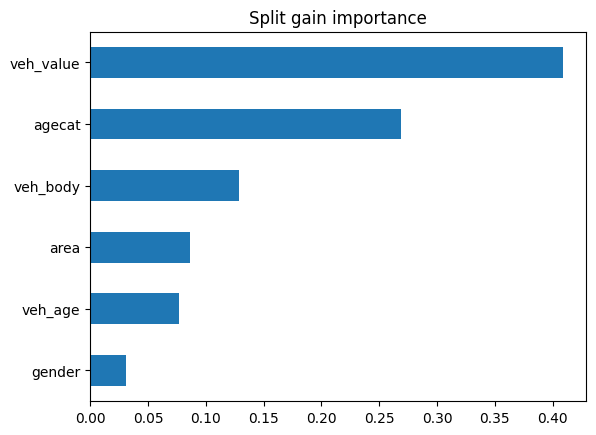

In [10]:
# Variable importance
feature_names = model[0].get_feature_names_out()
imps = pd.Series(model[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot(kind="barh", title="Split gain importance")

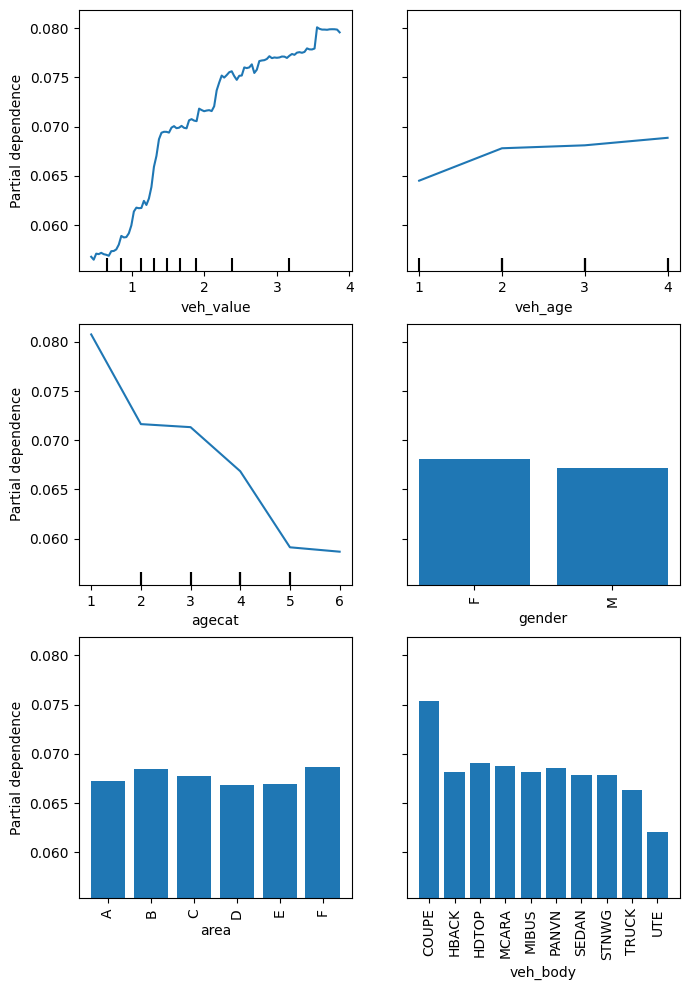

In [13]:
# Partial dependence plots
fig, axes = plt.subplots(figsize=(7, 10))

PartialDependenceDisplay.from_estimator(
    model,
    features=feature_names,
    categorical_features=cat_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()

**Comment:** Test performance with small tree depth seems to be best. When studying relative performance metrics like the relative deviance gain, we can see that performance of the model is very low. TPL claims seem to be mostly determined by bad luck, which makes sense.

## Exercises on Boosting

### Exercise 1

In [14]:
# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=49
)

# Preprocessing
ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

tree_encoder = ColumnTransformer(
    [
        ("asis", "passthrough", ["carat"]),
        ("prep", OrdinalEncoder(categories=ord_levels), ord_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

X_train = tree_encoder.fit_transform(df_train)
X_train.head()


,carat,color,cut,clarity
53763,0.76,3.0,2.0,4.0
41292,0.73,3.0,3.0,7.0
40463,0.32,0.0,0.0,1.0
3842,0.90,5.0,2.0,4.0
12445,1.17,6.0,0.0,3.0


In [15]:
# Load grid
grid_file = Path("gridsearch") / "diamonds_xgb.txt"

with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")
search_df.head(1)

,num_boost_round,cv_score,train_score,params
23,355,543.474377,509.026808,"{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha..."


In [16]:
# Set monotone constraints in right order
bst = search_df.iloc[0]
bst.params["monotone_constraints"] = "(1, 0, 0, 0)"  # Strange API
bst.params

{'subsample': 0.8,
 'reg_lambda': 0,
 'reg_alpha': 0,
 'objective': 'reg:squarederror',
 'min_split_loss': 0.0001,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.02,
 'colsample_bynode': 0.8,
 'monotone_constraints': '(1, 0, 0, 0)'}

In [18]:
# Fit on best params
xgbmodel = XGBRegressor(
    **bst.params,
    n_estimators=bst.num_boost_round,
    random_state=5,
)
_ = model = make_pipeline(tree_encoder, xgbmodel).fit(X=df_train, y=y_train)

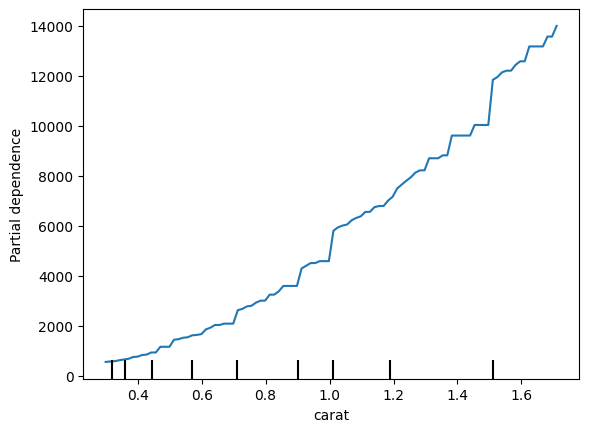

In [19]:
# Partial dependence plot of carat
_ = PartialDependenceDisplay.from_estimator(
    model, features=["carat"], X=df_train.sample(n=1000, random_state=1)
)

**Comment:** The argument is called "monotone_constraints". For each covariate, a value 0 means no constraint, a value -1 means a negative constraints, and a value 1 means positive constraint. Applying the constraint leads to a partial dependence plot that is guaranteed to be monotonically increasing. This is extremely useful in practice. Besides monotonic constraints, also interaction constraints are possible.

### Exercise 2

In [20]:
# We adapt the template from the lecture notes

# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    car, car["clm"], test_size=0.2, random_state=5684, stratify=car["clm"]
)

# Model pipeline. For simplicity, we treat 'veh_body' as ordinal
num_vars = ["veh_value", "veh_age", "agecat"]
cat_vars = ["gender", "area", "veh_body"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", "passthrough", num_vars),
        ("ordinal", OrdinalEncoder(), cat_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

dtrain = xgb.DMatrix(preprocessor.fit_transform(df_train), label=y_train)

In [21]:
# Step 1: Find learning rate with reasonable tree count
params = {"objective": "binary:logistic", "learning_rate": 0.01}

# Cross-validation
cvm = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    nfold=5,
    stratified=True,
    early_stopping_rounds=20,
    callbacks=[xgb.callback.EvaluationMonitor(period=50)],
)

# A LR of 0.01 provides about 300 trees, which is convenient
print("Best boosting round with default params:\n", cvm.tail(1))

[0]	train-logloss:0.28074	test-logloss:0.28077


[50]	train-logloss:0.26106	test-logloss:0.26235
[100]	train-logloss:0.25178	test-logloss:0.25423
[150]	train-logloss:0.24722	test-logloss:0.25085
[200]	train-logloss:0.24479	test-logloss:0.24953
[250]	train-logloss:0.24332	test-logloss:0.24910
[300]	train-logloss:0.24235	test-logloss:0.24900
[321]	train-logloss:0.24200	test-logloss:0.24900
Best boosting round with default params:
      train-logloss-mean  train-logloss-std  test-logloss-mean  \
301            0.242329           0.000188           0.248999   

     test-logloss-std  
301          0.000425  


In [22]:
# Step 2: Iterate randomized SearchCV for regularization parameters
grid_file = Path("gridsearch") / "claims_xgb.txt"

if False:
    # Use ParameterGrid(...) if grid is small enough to check all combinations

    # Final grid search after some iterations
    grid = ParameterSampler(
        {   
            "objective": ["binary:logistic"],
            "learning_rate": [0.01],
            "max_depth": [3, 4, 5, 6],
            "colsample_bynode": [0.8, 1],
            "subsample": [0.8, 1],
            "reg_lambda": [0, 2.5, 5, 7.5],
            "reg_alpha": [0, 4],
            "min_child_weight": [0, 0.1],  # *not* the number of obs with logloss
            "min_split_loss": [0, 0.0001],
        },
        n_iter=32,        
        random_state=40,
    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = xgb.cv(
            params=g,
            dtrain=dtrain,
            num_boost_round=5000,
            nfold=5,
            stratified=True,
            early_stopping_rounds=20,
        )
        # Keep number of rounds, cv score, train score, and parameters
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

,num_boost_round,cv_score,train_score,params
2,452,0.247948,0.246709,"{'subsample': 1, 'reg_lambda': 2.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 0.8}"
22,388,0.247956,0.246838,"{'subsample': 1, 'reg_lambda': 0, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0, 'min_child_weight': 0, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 0.8}"
26,415,0.247981,0.246750,"{'subsample': 0.8, 'reg_lambda': 2.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 0.8}"
30,415,0.247982,0.246750,"{'subsample': 0.8, 'reg_lambda': 2.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0.0001, 'min_child_weight': 0, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 0.8}"
21,413,0.248005,0.246754,"{'subsample': 1, 'reg_lambda': 7.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0.0001, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 1}"


In [23]:
# Step 3: Fit on best params
best = search_df.iloc[0]
best.num_boost_round, best.params

(452,
 {'subsample': 1,
  'reg_lambda': 2.5,
  'reg_alpha': 4,
  'objective': 'binary:logistic',
  'min_split_loss': 0,
  'min_child_weight': 0.1,
  'max_depth': 3,
  'learning_rate': 0.01,
  'colsample_bynode': 0.8})

In [24]:
xgbmodel = XGBClassifier(
    **best.params,
    n_estimators=best.num_boost_round,
    random_state=5,
    importance_type="gain"
)
_ = model = make_pipeline(preprocessor, xgbmodel).fit(X=df_train, y=y_train)

In [25]:
# Interpret model

# Performance on test data
test_loss = log_loss(y_test, model.predict_proba(df_test))
test_loss0 = log_loss(y_test, np.repeat(y_train.mean(), len(y_test)))
rel_imp = (test_loss0 - test_loss) / test_loss0

print(f"Average test log loss: {test_loss: .3f}")
print(f"Relative improvement in average log loss: {rel_imp: .3%}")

Average test log loss:  0.248
Relative improvement in average log loss:  0.175%


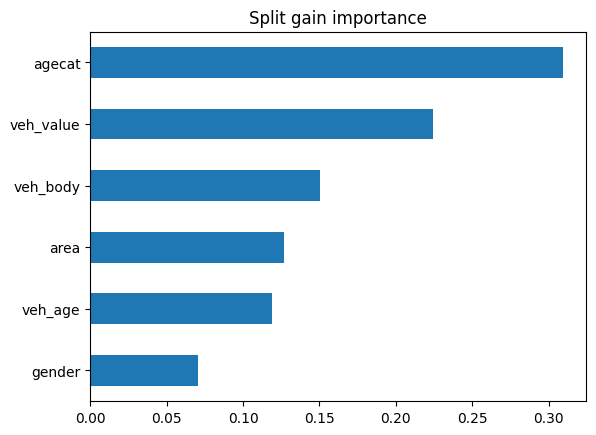

In [26]:
# Split gain importance
feature_names = model[:-1].get_feature_names_out()
imps = pd.Series(model[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot.barh(title="Split gain importance")

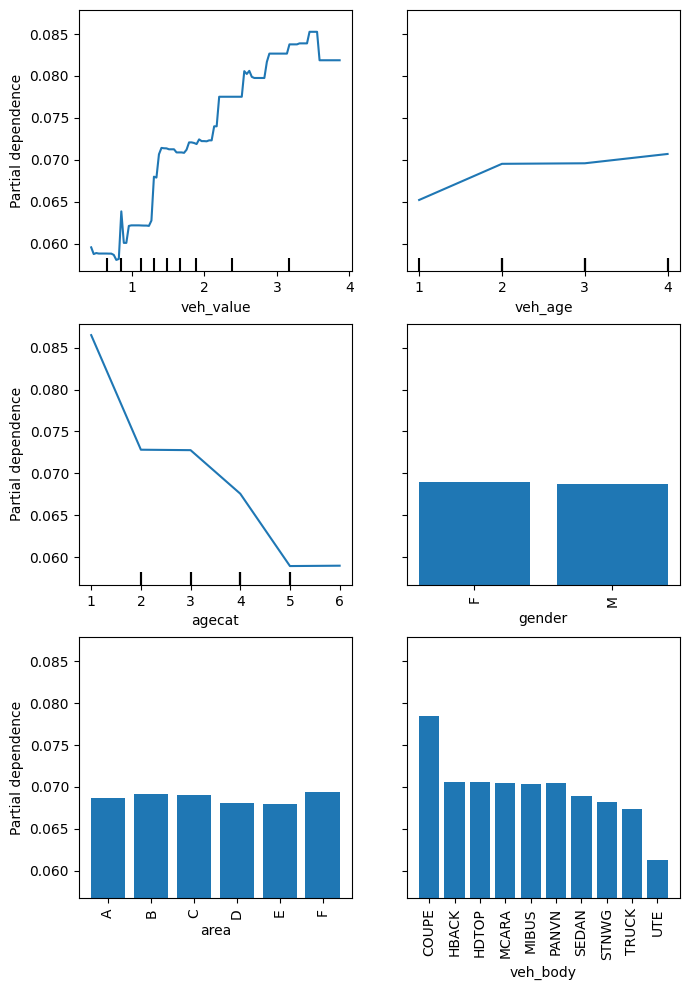

In [27]:
# Partial dependence plots
fig, axes = plt.subplots(figsize=(7, 10))

PartialDependenceDisplay.from_estimator(
    model,
    features=feature_names,
    categorical_features=cat_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()

### Exercise 3 (Optional)

In [28]:
# We reuse and adapt the code from Exercise 2
dtrain = lgb.Dataset(preprocessor.fit_transform(df_train), label=y_train)

In [29]:
# Step 1: Find learning rate with reasonable tree count
params = {
    "learning_rate": 0.002,
    "objective": "binary",
    "verbose": -1,
}

# Cross-validation
cvm = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=5000,
    nfold=5,
    stratified=True,
    eval_train_metric=True,
    callbacks=[lgb.log_evaluation(period=0), lgb.early_stopping(20, verbose=0)],
)

# A LR of 0.002 provides about 340 trees, which is convenient
cvm = pd.DataFrame(cvm)
print("Best boosting round with default params:\n", len(cvm))
cvm.tail(1)

Best boosting round with default params:
 341


,train binary_logloss-mean,train binary_logloss-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
340,0.246029,0.000088,0.248273,0.000315


In [30]:
# Step 2: Iterate randomized SearchCV for regularization parameters
grid_file = Path("gridsearch") / "claims_lgb.txt"

if True:
    # Final grid search after some iterations
    grid = ParameterSampler(
        {
            "objective": ["binary"],
            "learning_rate": [0.002],
            "num_leaves": [15, 31, 63],
            "reg_lambda": [0, 4],
            "reg_alpha": [0, 2.5, 5, 7.5],
            "colsample_bynode": [0.8, 1],
            "bagging_fraction": [0.8, 1],
            "min_child_samples": [20, 50, 100],
            "verbose": [-1],
        },
        n_iter=32,
        random_state=94,

    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = lgb.cv(
            params=g,
            train_set=dtrain,
            num_boost_round=5000,
            nfold=5,
            stratified=True,
            seed=82,
            eval_train_metric=True,
            callbacks=[lgb.log_evaluation(period=0), lgb.early_stopping(20, verbose=0)],
        )
        # Keep number of rounds, cv score, train score, and parameters
        cvm = pd.DataFrame(cvm)
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

100%|██████████| 32/32 [10:39<00:00, 19.98s/it]


,num_boost_round,cv_score,train_score,params
5,821,0.248130,0.246232,"{'verbose': -1, 'reg_lambda': 0, 'reg_alpha': 2.5, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 20, 'learning_rate': 0.002, 'colsample_bynode': 0.8, 'bagging_fraction': 1}"
24,819,0.248138,0.246251,"{'verbose': -1, 'reg_lambda': 0, 'reg_alpha': 2.5, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 50, 'learning_rate': 0.002, 'colsample_bynode': 0.8, 'bagging_fraction': 1}"
2,881,0.248139,0.246472,"{'verbose': -1, 'reg_lambda': 0, 'reg_alpha': 5, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 20, 'learning_rate': 0.002, 'colsample_bynode': 1, 'bagging_fraction': 0.8}"
3,824,0.248141,0.246152,"{'verbose': -1, 'reg_lambda': 4, 'reg_alpha': 0, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 50, 'learning_rate': 0.002, 'colsample_bynode': 0.8, 'bagging_fraction': 0.8}"
12,687,0.248153,0.246990,"{'verbose': -1, 'reg_lambda': 4, 'reg_alpha': 7.5, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 100, 'learning_rate': 0.002, 'colsample_bynode': 0.8, 'bagging_fraction': 0.8}"


In [31]:
# Best parameters
best = search_df.iloc[0]
best.num_boost_round, best.params

(821,
 {'verbose': -1,
  'reg_lambda': 0,
  'reg_alpha': 2.5,
  'objective': 'binary',
  'num_leaves': 15,
  'min_child_samples': 20,
  'learning_rate': 0.002,
  'colsample_bynode': 0.8,
  'bagging_fraction': 1})

In [32]:
# Step 3: Fit on best params
model = make_pipeline(
    preprocessor,
    LGBMRegressor(**best.params, n_estimators=best.num_boost_round, random_state=59)
)
_ = model.fit(X=df_train, y=y_train)

d:\ml_lecture\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\ml_lecture\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [33]:
# Interpret model

# Performance on test data
test_loss = log_loss(y_test, model.predict(df_test))
test_loss0 = log_loss(y_test, np.repeat(y_train.mean(), len(y_test)))
rel_imp = (test_loss0 - test_loss) / test_loss0

print(f"Average test log loss: {test_loss: .3f}")
print(f"Relative improvement in average log loss: {rel_imp: .3%}")

Average test log loss:  0.248
Relative improvement in average log loss:  0.232%


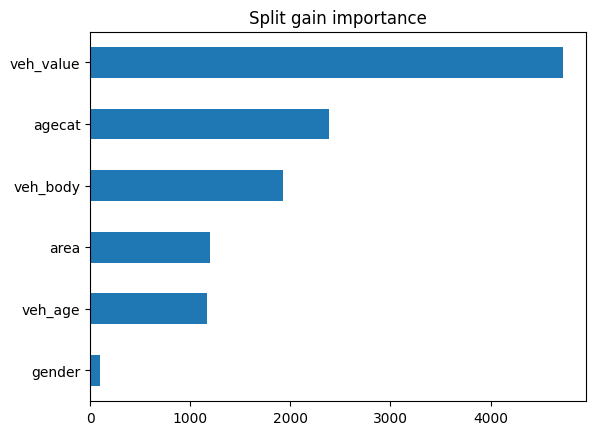

In [34]:
# Split gain importance
feature_names = model[:-1].get_feature_names_out()
imps = pd.Series(model[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot.barh(title="Split gain importance")

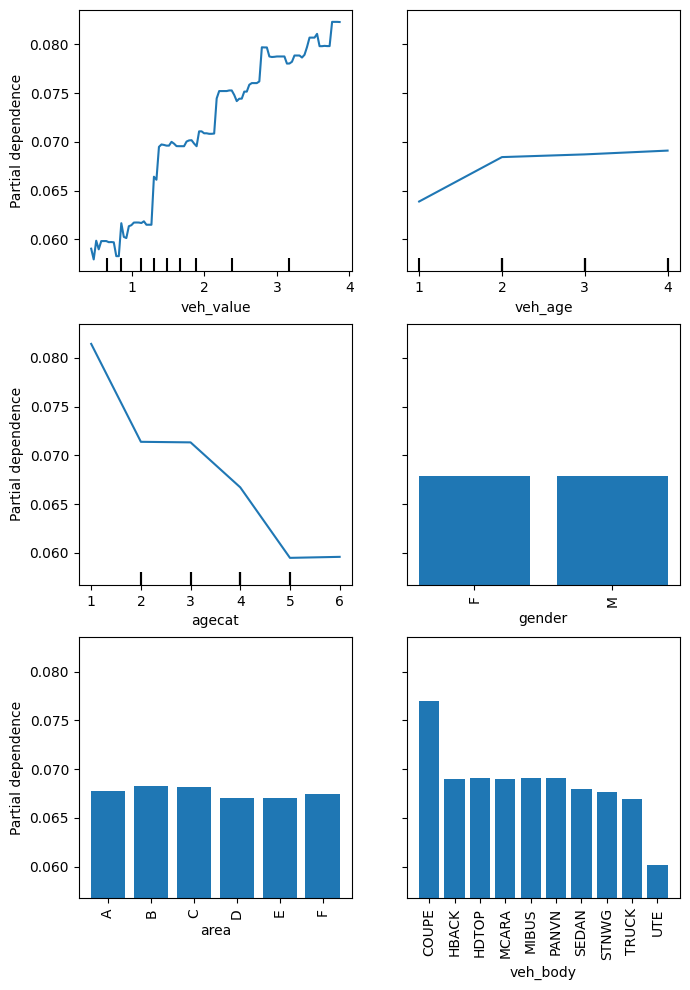

In [35]:
# Partial dependence plots
fig, axes = plt.subplots(figsize=(7, 10))

PartialDependenceDisplay.from_estimator(
    model,
    features=feature_names,
    categorical_features=cat_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()

# Chapter 4: Neural Nets

## Exercise 1

In [1]:
# Load data and specify preprocessing
from plotnine.data import diamonds
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

diamonds["price"] = diamonds["price"].astype("float32")  # for TensorFlow

df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=341
)

ord_features = ["cut", "color", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_features]

preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("ordinal", OrdinalEncoder(categories=ord_levels), ord_features),
            ("numeric", "passthrough", ["carat"]),
        ]
    ),
    StandardScaler(),
)

X_train = preprocessor.fit_transform(df_train)
X_test = preprocessor.transform(df_test)
X_test[0:5]

array([[ 0.98143089, -1.5256479 ,  0.57680845, -0.60749424],
       [-0.80744346, -1.5256479 , -1.24422106,  1.01420318],
       [-0.80744346,  0.82624444, -0.63721122, -0.0809691 ],
       [ 0.98143089, -0.34970173, -0.03020138, -0.96553133],
       [-2.5963178 , -0.93767482, -0.63721122,  0.42449503]])

In [2]:
# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K


def loss_gamma(y_true, y_pred):
    return -K.log(y_true / y_pred) + y_true / y_pred


inputs = keras.Input(shape=4)
x = layers.Dense(30, activation="tanh")(inputs)
x = layers.Dense(15, activation="tanh")(x)
outputs = layers.Dense(1, activation=K.exp)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss=loss_gamma, optimizer=keras.optimizers.Adam(learning_rate=0.001))

cb = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ReduceLROnPlateau(patience=5),
]

tf.random.set_seed(873)

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    batch_size=400,
    validation_split=0.2,
    callbacks=cb,
    verbose=0,
)

c:\Users\Michael\anaconda3\envs\ml_lecture\lib\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


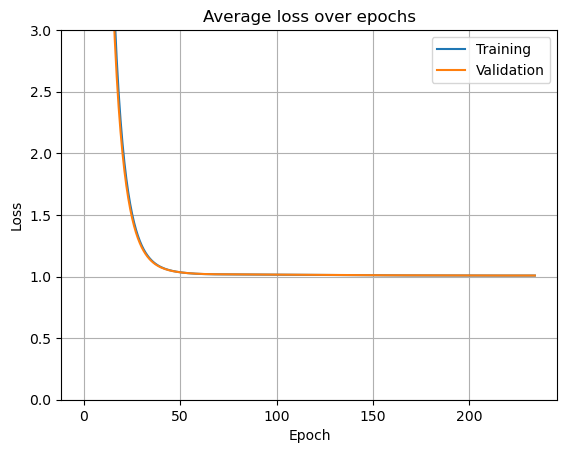

In [3]:
# Average loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.gca().set(
    title="Average loss over epochs", xlabel="Epoch", ylabel="Loss", ylim=(0, 3),
)
plt.grid()
plt.show()

In [6]:
# Interpretation
import dalex as dx
from sklearn.metrics import mean_gamma_deviance as deviance
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor().fit(X_train, y_train)
d0, d = (deviance(y_test, m.predict(X_test)) for m in (dummy, model))
print(f"% deviance explained: {(d0 - d) / d0:.2%}")

338/338 [==============================] - 2s 5ms/step
% deviance explained: 98.37%


In [10]:
def pred_fun(m, X):
    return m.predict(preprocessor.transform(X), batch_size=1000, verbose=0).flatten()


exp = dx.Explainer(
    model,
    data=df_test[ord_features + ["carat"]],
    y=y_test,
    predict_function=pred_fun,
    verbose=False,
)

vi = exp.model_parts()
vi.plot()

In [11]:
pdp_num = exp.model_profile(
    variables=["carat"], label="Partial depencence for numeric variables", verbose=False
)
pdp_num.plot()

pdp_ord = exp.model_profile(
    variable_type="categorical",
    variable_splits=dict(zip(ord_features, ord_levels)),
    label="Partial depencence for ordinal variables",
    verbose=False,
)
pdp_ord.plot(facet_scales="free")

## Exercise 2

See lecture notes for a solution with embeddings